# How to use `scivision`

In this notebook, we will:

1. Demonstrate using the scivision [Python API](https://scivision.readthedocs.io/en/latest/api.html) to load several pretrained image classification models
2. Use the scivision catalog to find a matching dataset, which the model can be run on
3. Run the model on the data, performing simple model inference
4. Use the scivision catalog to find another model that can be run on the same dataset

First let's import some things from scivision: `default_catalog` is a scivision **catalog** that will let us discover models and datasets, and `load_pretrained_model` provides a convenient way to load and run a model.

In [ ]:
from scivision import default_catalog, load_pretrained_model

pee =  default_catalog.models.to_dataframe()
pee

## Inspecting our model in the scivision catalog

A scivision catalog is a collection of **models** and **datasources**.

For this example, we want to find datasources compatible with the model catalog entry "image-classifiers".  But first, let's use the catalog to retrive the "image-classifiers" repository url and take a look at the data contained in the *default catalog* (the built-in catalog, distributed as part of scivision) and see how this is structured.

In [ ]:
# Get the model repo url
models_catalog = default_catalog.models.to_dataframe()
model_repo = models_catalog[models_catalog.name == "catdog_classification_model"].url.item()
model_repo # Why not paste the repo link into your browser and see how it looks?

In [ ]:
# Inspecting model entry and its metadata in the default catalog
models_catalog[models_catalog.name == "image-classifiers"]

## Loading the model

Some model entries in the scivision catalog contain a single loadable model. Here, let's load the "image-classifiers" entry, which contains each of the models in the [image-classifiers](https://pypi.org/project/image-classifiers/) package. We can do this with the `load_pretrained_model` function. We'll load 2 models (`resnet18` and `densenet121`).

Note: the "model" arg is not mandatory and will have a default value for any model catalog entries that have more than one model - for model catalog entries with a single model, this need not be set:

In [ ]:
# Note: when loading this model repo for the first time you'll need to add the allow_install=True flag
cat_dog_classifier = load_pretrained_model(model_repo, allow_install=True)

In [ ]:
# let's explore one of the model objects
cat_dog_classifier

Later, we'll use these models to make predictions on image data found in the scivision catalog.

## Query the default scivision data catalog

Now let's use the `default_catalog` to identify datasources in the catalog that are compatible with our models (based on `tasks`, `format` and `labels_provided`/`labels_required`).

In [ ]:
compatible_datasources = default_catalog.compatible_datasources("image-classifiers").to_dataframe()
compatible_datasources

Let's use `data-000`, an image dataset containing a single image of a Koala.

In [ ]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'data-000']
target_datasource

## Load the dataset

Now let's load the dataset using the scivision python API, specifically the [load_dataset](https://scivision.readthedocs.io/en/latest/api.html#scivision.io.reader.load_dataset) function, which takes as input the url of the data repository (structured as per [this template](https://scivision.readthedocs.io/en/latest/data_repository_template.html)), which we can get from the target datasource:

In [ ]:
from scivision import load_dataset

In [ ]:
data_url = target_datasource['url'].item()
# target_datasource['url'].items()

The returned data config object of the`load_dataset` function is an "intake catalog". You can read our [documentation](https://scivision.readthedocs.io/en/latest/data_repository_template.html#data-config-file) to understand this better, but for now, let's inspect this config:

In [ ]:
data_config = load_dataset(data_url)
data_config

Clicking the `path` link to the location of this data config file online (in the dataset repo) reveals that there is one data source called `test_image`, and that the `intake_xarray.image.ImageSource` "intake driver" is being used. We can retrive the test image data in an image format which the model will accept, like so:

In [ ]:
test_image = data_config.catdog().to_dask() # The xarray.DataArray is one format accepted by the our models
# images= test_image.to_array()

Let's take a look at the image with `matplotlib`:

In [ ]:
import matplotlib.pyplot as plt



In [ ]:
subset = test_image.sel(concat_dim=6000)
plt.imshow(subset['raster'].compute().values[:,:,:])
plt.show()


pee = subset['raster'].compute()

## Model predictions

Now let's use the loaded model on the test image data we found in the via catalog.

In [ ]:
answer = cat_dog_classifier.predict(pee)
classes = ["cat", "dog"]

In [ ]:
catlikelihood = float(answer[0][0])
doglikelihood = float(answer[0][1])

print("cat is ",catlikelihood)
print("dog is",doglikelihood)

In [ ]:
if catlikelihood >= 0:
    print("IT's a fuckin cat mate ",catlikelihood)
if doglikelihood >= 0: 
    print("It's a dog, innit",doglikelihood)
if doglikelihood <= 0 and catlikelihood <= 0:
    print("what on earth is that?")

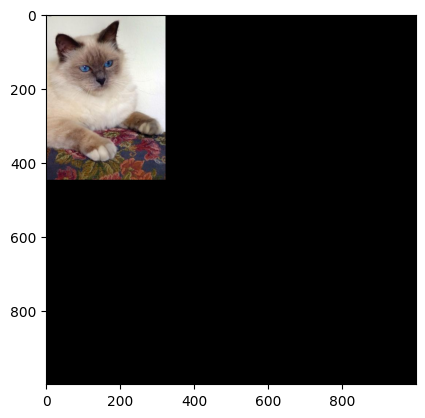

cat is  0.6880709528923035
dog is -0.5974787473678589


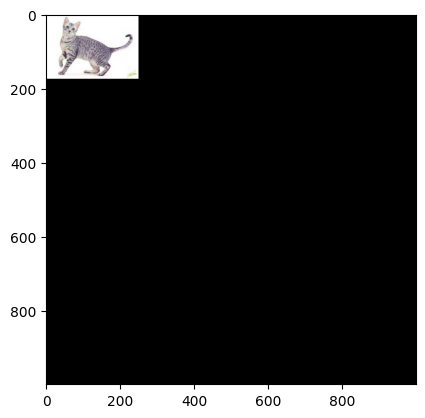

cat is  0.6816807985305786
dog is -0.6064003705978394


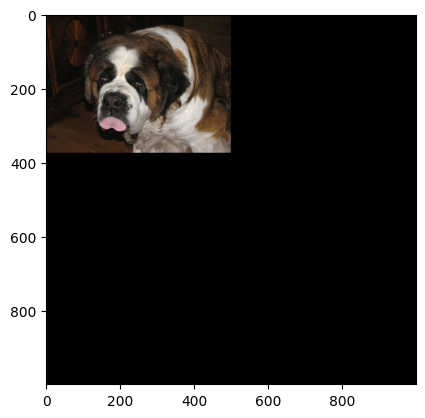

cat is  0.5933728218078613
dog is -0.4754670262336731


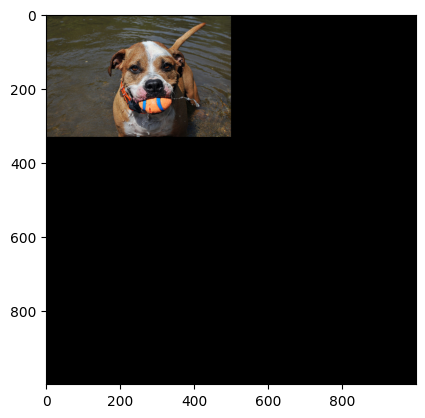

cat is  0.6094827651977539
dog is -0.5056039094924927


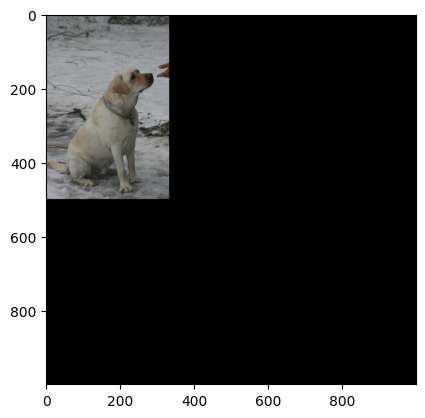

cat is  0.6307533979415894
dog is -0.5351094007492065


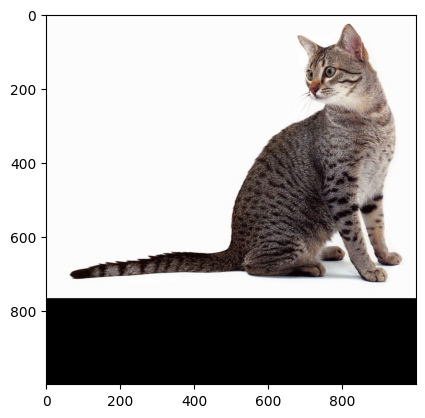

cat is  0.11173135042190552
dog is 0.16701377928256989


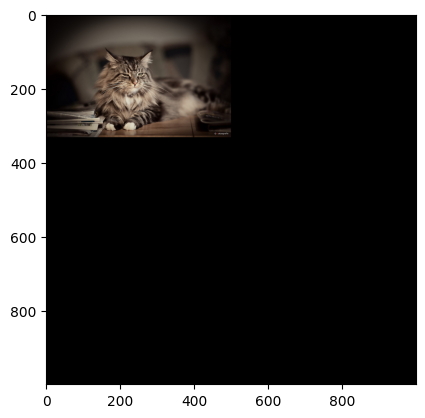

cat is  0.6471286416053772
dog is -0.56083083152771


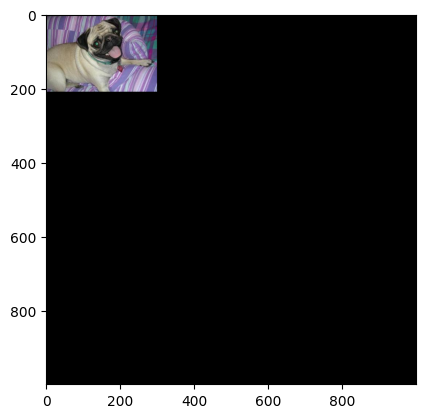

cat is  0.6519703269004822
dog is -0.5683146715164185


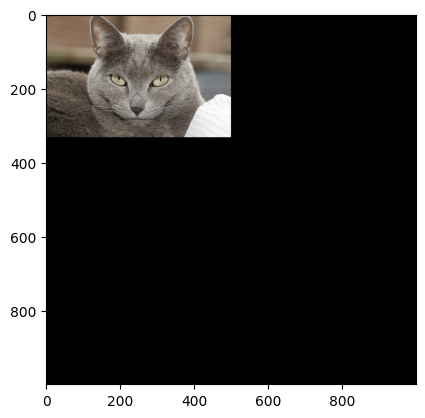

cat is  0.5888833999633789
dog is -0.4779067039489746


In [45]:
randomdogsorcats = [550,1000,6000,2405,4034,1024,1249,5839,1839]

for image in randomdogsorcats:
    subset = test_image.sel(concat_dim=image)
    


    pee = subset['raster'].compute()
    answer = cat_dog_classifier.predict(pee)
    catlikelihood = float(answer[0][0])
    doglikelihood = float(answer[0][1])

    plt.imshow(subset['raster'].compute().values[:,:,:])
    plt.show()
    print("cat is ",catlikelihood)
    print("dog is",doglikelihood)


As you can see, the models have given predictions for the test image, with a confidence score. Check out the code in the [model repo](https://github.com/alan-turing-institute/scivision_classifier) to see how this was determined!

## Query the default scivision model catalog

Using our test Koala image dataset, let's search the scivision default catalog for other models that can be used with it:

In [ ]:
compatible_models = default_catalog.compatible_models("data-003").to_dataframe()
compatible_models

The `huggingface-classifiers` catalog entry can be used to load some of the most popular image classification models from [Hugging Face](https://huggingface.co/models?pipeline_tag=image-classification&sort=downloads). See the list of included models in the [model repo](https://github.com/alan-turing-institute/scivision_huggingface). As before, let's load one of the named models and run it on our test image:

In [ ]:
huggingface_repo = models_catalog[models_catalog.name == "huggingface-classifiers"].url.item()
microsoft_model = load_pretrained_model(huggingface_repo, model='microsoft_swin_tiny_patch4_window7_224', allow_install=True)

In [ ]:
microsoft_model.predict(test_image)